 Name: Bhakti Bagadia

 Roll No.: A1_02

 Sec: A

 Practical No. : 06

Aim: Write a program to implement Decision Tree algorithm

Implementation using ID3 algorithm

In [ ]:
import pandas as pd #for manipulating the csv data
import numpy as np #for mathematical calculation

In [ ]:
train_data_m = pd.read_csv("/content/PlayTennis.csv") #importing the dataset from the disk

train_data_m.head() #viewing some row of the dataset

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [ ]:
def calc_total_entropy(train_data, label, class_list):
    total_row = train_data.shape[0] #the total size of the dataset
    total_entr = 0

    for c in class_list: #for each class in the label
        total_class_count = train_data[train_data[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset

    return total_entr

In [ ]:
def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0

    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

In [ ]:
def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0

    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value

    return calc_total_entropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting

In [ ]:
def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature

In [ ]:
def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node

    for feature_value, count in feature_value_count_dict.iteritems():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value

        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further,
                                      #so the branch is marking with ?

    return tree, train_data

In [ ]:
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None

        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]

        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset

In [ ]:
def id3(train_data_m, label):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data, label, class_list) #start calling recursion
    return tree

In [ ]:
tree = id3(train_data_m, 'play')
print(tree)

{'outlook': {'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}}, 'overcast': 'yes', 'rainy': {'windy': {False: 'yes', True: 'no'}}}}


<ipython-input-7-4759aa9c3475>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-7-4759aa9c3475>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-7-4759aa9c3475>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():


In [ ]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

In [ ]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy

In [ ]:
test_data_m = pd.read_csv("/content/PlayTennis.csv") #importing test dataset into dataframe

accuracy = evaluate(tree, test_data_m, 'play') #evaluating the test dataset

In [ ]:
print(accuracy)

1.0


In [ ]:
print('Play Tennis:',tree['outlook']['sunny']['humidity']['high'])


Play Tennis: no


In [ ]:
print('Play Tennis:',tree['outlook']['overcast'])

Play Tennis: yes


In [ ]:
print('Play Tennis:',tree['outlook']['rainy']['windy'])

Play Tennis: {False: 'yes', True: 'no'}


# **Implementation using Scikit Learn**

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
df=pd.read_csv("/content/PlayTennis.csv")
value=['outlook','temp','humidity','windy']
df

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [ ]:
len(df)           #Dataset Lenght


14

In [ ]:
df.shape  #To see the number of rows and columns in our dataset:

(14, 5)

In [ ]:
df.head()         #To inspect the first five records of the dataset:

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [ ]:
df.tail()         #To inspect the last five records of the dataset:

,outlook,temp,humidity,windy,play
9,rainy,mild,normal,False,yes
10,sunny,mild,normal,True,yes
11,overcast,mild,high,True,yes
12,overcast,hot,normal,False,yes
13,rainy,mild,high,True,no


In [ ]:
df.describe()     #To see statistical details of the dataset:

,outlook,temp,humidity,windy,play
count,14,14,14,14,14
unique,3,3,2,2,2
top,sunny,mild,high,False,yes
freq,5,6,7,8,9


In [ ]:
#encode it to int
from sklearn import preprocessing
string_to_int= preprocessing.LabelEncoder() #encode your data
df=df.apply(string_to_int.fit_transform) #fit and transform it
df

,outlook,temp,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [ ]:
#To divide our data into attribute set and Label:
feature_cols = ['outlook','temp','humidity','windy']
X = df[feature_cols ]                               #contains the attribute
y = df.play                                  #contains the label

In [ ]:
#To divide our data into training and test sets:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
# perform training
from sklearn.tree import DecisionTreeClassifier                             # import the classifier
classifier =DecisionTreeClassifier(criterion="entropy", random_state=100)     # create a classifier object
classifier.fit(X_train, y_train)                                              # fit the classifier with

DecisionTreeClassifier(criterion='entropy', random_state=100)

In [ ]:
#Predict the response for test dataset
y_pred= classifier.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8


In [ ]:
data_p=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
data_p

,Actual,Predicted
2,1,1
13,0,1
12,1,1
0,0,0
4,1,1


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1 1]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



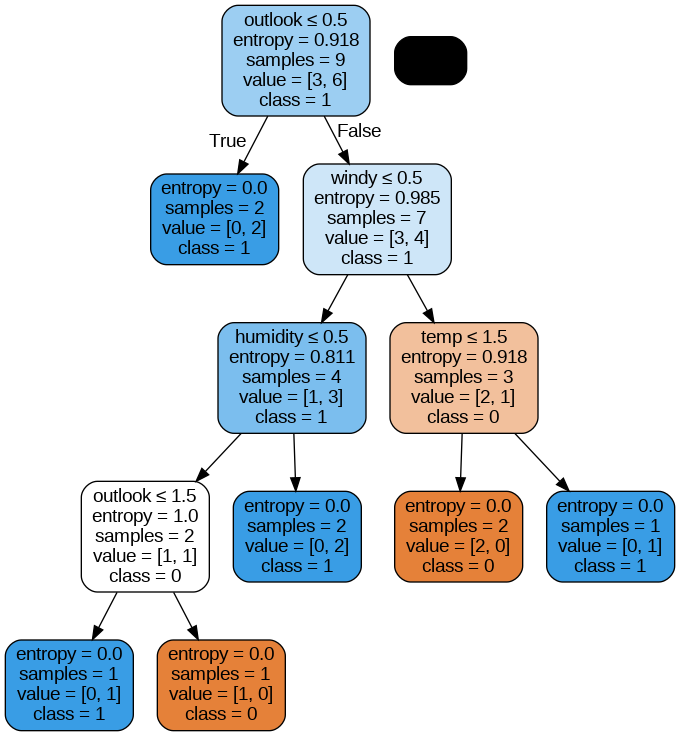

In [ ]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=value, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Play Tennis.png')
Image(graph.create_png())
